**Hold Segmentation**

In [4]:
import cv2
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

/opt/anaconda3/envs/E208_F24/lib/python3.11/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=to

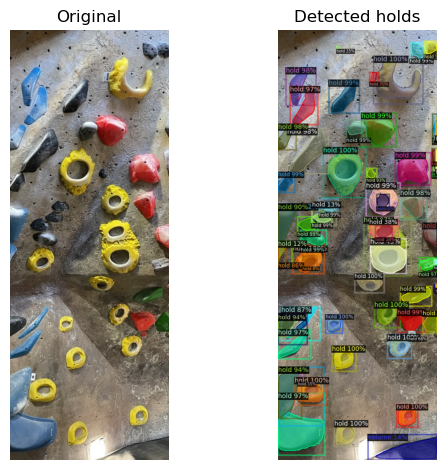

In [19]:
# Get config and weigths for model
cfg = get_cfg()
cfg.merge_from_file("ml/weights/experiment_config.yml")
cfg.MODEL.WEIGHTS = "ml/weights/model_final.pth"
cfg.MODEL.DEVICE='cpu'
# Set metadata, in this case only the class names for plotting
MetadataCatalog.get("meta").thing_classes = ["hold", "volume"]
metadata = MetadataCatalog.get("meta")

predictor = DefaultPredictor(cfg)

img = cv2.imread("test_cropped.jpeg")
outputs = predictor(img)
v = Visualizer(
    img[:, :, ::-1],
    metadata=metadata
)

out_predictions = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img_holds = out_predictions.get_image()

# display the results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_holds)
ax2.axis('off')
ax2.set_title('Detected holds')

fig.tight_layout()
fig.savefig('holds.png', dpi=300)
plt.show()

**Route Segmentation**

In [6]:
import cv2
import torch
import random
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from ml.route_networks import TripletNet
from collections import defaultdict
from ml.utils import plot_routes_instances, instance_to_hold
random.seed(42)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get config and weigths for model
cfg = get_cfg()
cfg.merge_from_file("ml/weights/experiment_config.yml")
cfg.MODEL.WEIGHTS = "ml/weights/model_final.pth"
cfg.MODEL.DEVICE='cpu'
# Set metadata, in this case only the class names for plotting
MetadataCatalog.get("meta").thing_classes = ["hold", "volume"]
metadata = MetadataCatalog.get("meta")

predictor = DefaultPredictor(cfg)

# Get holds
img = cv2.imread("test_cropped.jpeg")
outputs = predictor(img)


# Load weigths for TripletNet
triplet_model = TripletNet().to(device)
triplet_model.load_state_dict(torch.load("ml/weights/triplet_network_final.pt", map_location=device))

/opt/anaconda3/envs/E208_F24/lib/python3.11/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=to

<All keys matched successfully>

In [ ]:
instances = outputs["instances"]

# Filter to only include holds with scorces > 0.7
instances = instances[instances.pred_classes == 0]
instances = instances[instances.scores > 0.7]

# Initialize routes with random seed hold
routes_dict = defaultdict(list)
#routes_dict[0] = [random.randint(0,len(instances)-1)]

start_hold = 0

routes_dict[0] = [start_hold]


dict_items([(0, [0])])


hold: 0 of 46
hold: 1 of 46
hold: 2 of 46
hold: 3 of 46
hold: 4 of 46
hold: 5 of 46
hold: 6 of 46
hold: 7 of 46
hold: 8 of 46
hold: 9 of 46
hold: 10 of 46
hold: 11 of 46
hold: 12 of 46
hold: 13 of 46
hold: 14 of 46
hold: 15 of 46
hold: 16 of 46
hold: 17 of 46
hold: 18 of 46
hold: 19 of 46
hold: 20 of 46
hold: 21 of 46
hold: 22 of 46
hold: 23 of 46
hold: 24 of 46
hold: 25 of 46
hold: 26 of 46
hold: 27 of 46
hold: 28 of 46
hold: 29 of 46
hold: 30 of 46
hold: 31 of 46
hold: 32 of 46
hold: 33 of 46
hold: 34 of 46
hold: 35 of 46
hold: 36 of 46
hold: 37 of 46
hold: 38 of 46
hold: 39 of 46
hold: 40 of 46
hold: 41 of 46
hold: 42 of 46
hold: 43 of 46
hold: 44 of 46
hold: 45 of 46
defaultdict(<class 'list'>, {0: [0, 0, 1, 3, 5, 7, 8, 9, 11, 12, 13, 17, 18, 24, 25, 27, 30, 33, 36, 39, 41, 43, 44, 0, 1, 3, 5, 7, 8, 9, 0, 1, 3, 5, 7, 8, 9, 12, 13, 17, 18, 24, 25, 27, 30, 33, 36, 39, 41, 44]})


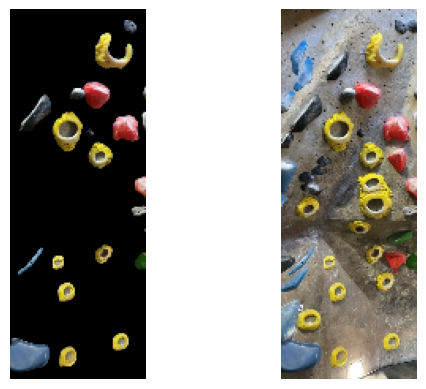

In [39]:
for hold_idx in range(len(instances)):
    print('hold:', hold_idx, 'of', len(instances))
    for route_id, holds in routes_dict.items():
        dists = []
        for route_hold_idx in holds:
            with torch.no_grad():
                input1 = instance_to_hold(instances[hold_idx], img, triplet_model.preprocess ,device).unsqueeze(0)
                input2 = instance_to_hold(instances[route_hold_idx], img, triplet_model.preprocess, device).unsqueeze(0)
                output1 = triplet_model(input1)
                output2 = triplet_model(input2)
            dist = torch.nn.functional.pairwise_distance(output1, output2).square().item()
            dists.append(dist)
        if np.median(np.array(dists)) <= 0.5 and np.max(dists) <= 1.65:
            # Current hold is similar to all holds in existing route => Adding it to that route
            routes_dict[route_id].append(hold_idx)
            break
    
print(routes_dict)

figures_axes = plot_routes_instances(routes_dict, instances, img)
for (fig, ax) in figures_axes:
    fig.canvas.draw()

0
1
1
2
2
2
3
3
3
4
4
4
4
4
5
5
5
5
6
6
6
6
6
6
6
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
25
25
25
25
25
25
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29

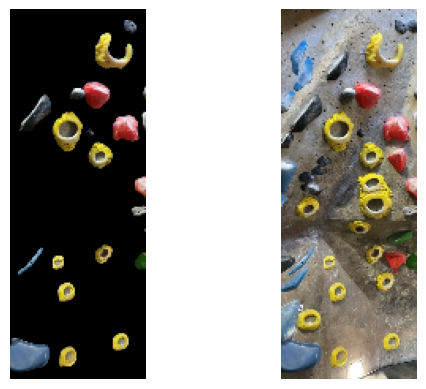

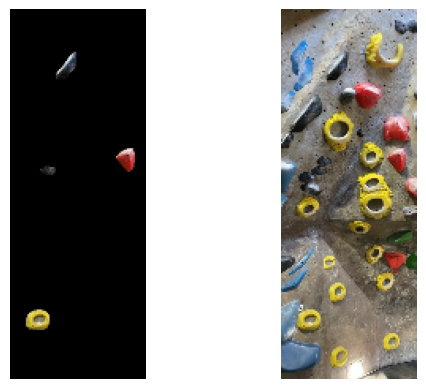

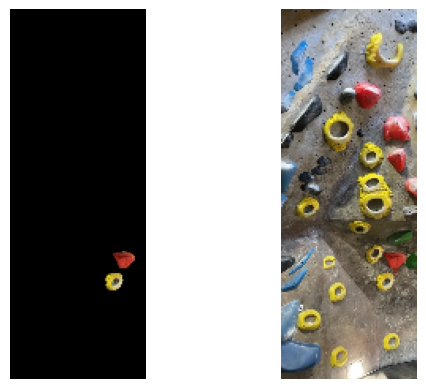

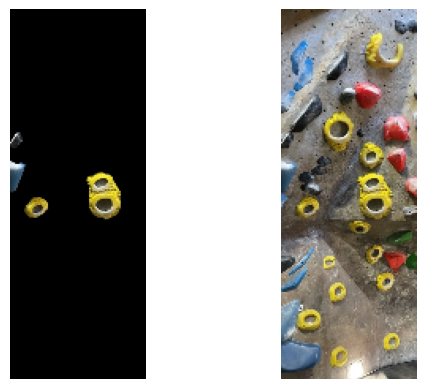

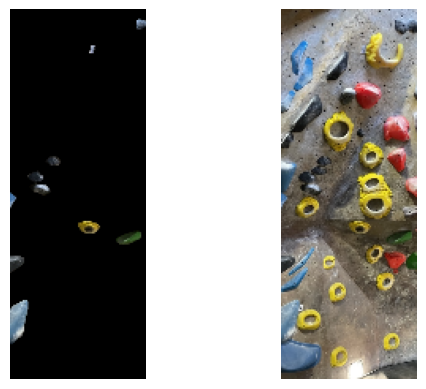

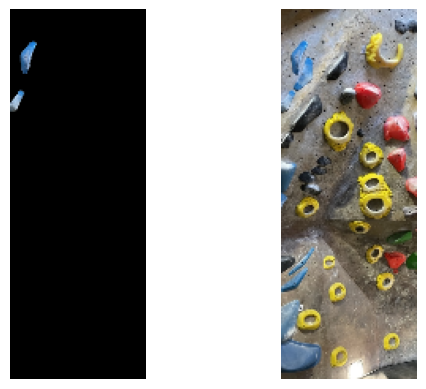

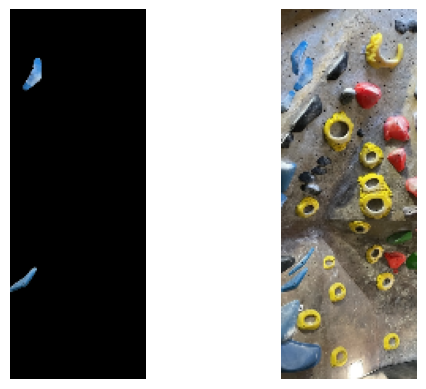

In [ ]:
# for hold_idx in range(len(instances)):
#     for route_id, holds in routes_dict.items():
#         dists = []
#         for route_hold_idx in holds:
#             print(hold_idx)
#             with torch.no_grad():
#                 input1 = instance_to_hold(instances[hold_idx], img, triplet_model.preprocess ,device).unsqueeze(0)
#                 input2 = instance_to_hold(instances[route_hold_idx], img, triplet_model.preprocess, device).unsqueeze(0)
#                 output1 = triplet_model(input1)
#                 output2 = triplet_model(input2)
#             dist = torch.nn.functional.pairwise_distance(output1, output2).square().item()
#             dists.append(dist)
#         if np.median(np.array(dists)) <= 0.5 and np.max(dists) <= 2.65:
#             # Current hold is similar to all holds in existing route => Adding it to that route
#             routes_dict[route_id].append(hold_idx)
#             break
#     else:
#         # Current hold is not similar to any holds on existing routes => Add new route
#         routes_dict[max(routes_dict.keys()) + 1].append(hold_idx)
# print(routes_dict)

# figures_axes = plot_routes_instances(routes_dict, instances, img)
# for (fig, ax) in figures_axes:
#     fig.canvas.draw()